# Parameter Values

In this notebook, we explain how parameter values are set for a model. Information on creating new parameter sets is provided in our [online documentation](https://docs.pybamm.org/en/latest/source/api/parameters/parameter_sets.html#adding-parameter-sets)

## Setting up parameter values

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import os

import matplotlib.pyplot as plt
import numpy as np

import pybamm

os.chdir(pybamm.__path__[0] + "/..")

Note: you may need to restart the kernel to use updated packages.


In `pybamm`, the object that sets parameter values for a model is the [`ParameterValues`](https://docs.pybamm.org/en/latest/source/api/parameters/parameter_values.html) class, which extends `dict`. This takes the values of the parameters as input, which can be either a dictionary,

In [2]:
param_dict = {"a": 1, "b": 2, "c": 3}
parameter_values = pybamm.ParameterValues(param_dict)
print(f"parameter values are {parameter_values}")

parameter values are {'Boltzmann constant [J.K-1]': np.float64(1.380649e-23),
 'Electron charge [C]': np.float64(1.602176634e-19),
 'Faraday constant [C.mol-1]': np.float64(96485.33212331001),
 'Ideal gas constant [J.K-1.mol-1]': np.float64(8.31446261815324),
 'a': 1,
 'b': 2,
 'c': 3}


or using one of the pre-set chemistries

In [3]:
chem_parameter_values = pybamm.ParameterValues("Marquis2019")
print(
    "Negative current collector thickness is {} m".format(
        chem_parameter_values["Negative current collector thickness [m]"]
    )
)

Negative current collector thickness is 2.5e-05 m


We can alter the values of parameters by updating the dictionary, by using the `update` method or by using the `[]` operator.

In [4]:
parameter_values["a"] = 2
parameter_values.update({"b": 3, "c": 4})
print(f"parameter values are {parameter_values}")

parameter values are {'Boltzmann constant [J.K-1]': np.float64(1.380649e-23),
 'Electron charge [C]': np.float64(1.602176634e-19),
 'Faraday constant [C.mol-1]': np.float64(96485.33212331001),
 'Ideal gas constant [J.K-1.mol-1]': np.float64(8.31446261815324),
 'a': 2,
 'b': 3,
 'c': 4}


Parameter values can either be numerical values, python functions or PyBaMM expressions. We can input functions into the parameter value like so (note we bypass the check that the parameter already exists):


In [5]:
def cubed(x):
    return x**3


parameter_values.update({"cube function": cubed}, check_already_exists=False)
print(f"parameter values are {parameter_values}")

parameter values are {'Boltzmann constant [J.K-1]': np.float64(1.380649e-23),
 'Electron charge [C]': np.float64(1.602176634e-19),
 'Faraday constant [C.mol-1]': np.float64(96485.33212331001),
 'Ideal gas constant [J.K-1.mol-1]': np.float64(8.31446261815324),
 'a': 2,
 'b': 3,
 'c': 4,
 'cube function': <function cubed at 0x34cda0720>}


We can also use a PyBaMM expression to set the parameter value, allowing us to set parameters based on other parameters: 

In [6]:
parameter_values.update({"a": pybamm.Parameter("b") + pybamm.Parameter("c")})

## Setting parameters for a PyBaMM model

We represent parameters in models using the classes [`Parameter`](https://docs.pybamm.org/en/latest/source/api/expression_tree/parameter.html) and [`FunctionParameter`](https://docs.pybamm.org/en/latest/source/api/expression_tree/parameter.html#pybamm.FunctionParameter). These cannot be evaluated directly,

In [7]:
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
c = pybamm.Parameter("c")
func = pybamm.FunctionParameter("cube function", {"a": a})

expr = a + b * c
try:
    expr.evaluate()
except NotImplementedError as e:
    print(e)

method self.evaluate() not implemented for symbol a of type <class 'pybamm.expression_tree.parameter.Parameter'>


However, the `ParameterValues` class can walk through an expression, changing an `Parameter` objects it sees to the appropriate `Scalar` and any `FunctionParameter` object to the appropriate `Function`, and the resulting expression can be evaluated

In [8]:
expr_eval = parameter_values.process_symbol(expr)
print(f"{expr_eval} = {expr_eval.evaluate()}")

19.0 = 19.0


In [9]:
func_eval = parameter_values.process_symbol(func)
print(f"{func_eval} = {func_eval.evaluate()}")

343.0 = 343.0


If a parameter needs to be changed often (for example, for convergence studies or parameter estimation), the `InputParameter` class should be used. This is not fixed by parameter values, and its value can be set on evaluation (or on solve):

In [10]:
d = pybamm.InputParameter("d")
expr = 2 + d
expr_eval = parameter_values.process_symbol(expr)
print("with d = {}, {} = {}".format(3, expr_eval, expr_eval.evaluate(inputs={"d": 3})))
print("with d = {}, {} = {}".format(5, expr_eval, expr_eval.evaluate(inputs={"d": 5})))

with d = 3, 2.0 + d = 5.0
with d = 5, 2.0 + d = 7.0


## Solving a model

The code below shows the entire workflow of:

1. Proposing a toy model
2. Discretising and solving it first with one set of parameters,
3. then updating the parameters and solving again

The toy model used is:
$$\frac{\mathrm{d} u}{\mathrm{d} t} = -a u$$

with initial conditions $u(0) = b$. The model is first solved with $a = 3, b = 2$, then with $a = -1, b = 2$

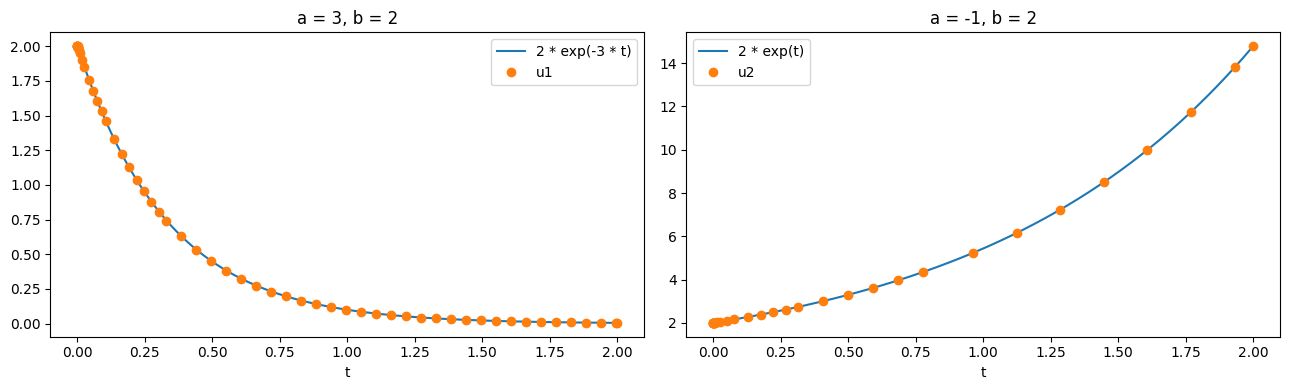

In [11]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
model.rhs = {u: -a * u}
model.initial_conditions = {u: b}
model.variables = {"u": u, "a": a, "b": b}

# Set parameters, with a as an input ########################
parameter_values = pybamm.ParameterValues({"a": "[input]", "b": 2})
parameter_values.process_model(model)
#############################################################

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model)

# Solve
t_eval = [0, 2]
ode_solver = pybamm.IDAKLUSolver()
solution = ode_solver.solve(model, t_eval, inputs={"a": 3})

# Post-process, so that u1 can be called at any time t (using interpolation)
t_sol1 = solution.t
u1 = solution["u"]

# Solve again with different inputs ###############################
solution = ode_solver.solve(model, t_eval, inputs={"a": -1})
t_sol2 = solution.t
u2 = solution["u"]
###################################################################

# Plot
t_fine = np.linspace(0, t_eval[-1], 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.plot(t_fine, 2 * np.exp(-3 * t_fine), t_sol1, u1(t_sol1), "o")
ax1.set_xlabel("t")
ax1.legend(["2 * exp(-3 * t)", "u1"], loc="best")
ax1.set_title("a = 3, b = 2")

ax2.plot(t_fine, 2 * np.exp(t_fine), t_sol2, u2(t_sol2), "o")
ax2.set_xlabel("t")
ax2.legend(["2 * exp(t)", "u2"], loc="best")
ax2.set_title("a = -1, b = 2")


plt.tight_layout()
plt.show()

In [12]:
model.rhs

{Variable(0x198a0cdd4acc6776, u, children=[], domains={}): Multiplication(0x601d4e0f24e8451d, *, children=['-a', 'y[0:1]'], domains={})}

## Printing parameter values

Since parameters objects must be processed by the `ParameterValues` class before they can be evaluated, it can be difficult to quickly check the value of a parameter that is a combination of other parameters. You can print all of the parameters (including combinations) in a model by using the `print_parameters` function.

In [13]:
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
parameter_values = pybamm.ParameterValues({"a": 4, "b": 3})
parameters = {"a": a, "b": b, "a + b": a + b, "a * b": a * b}
param_eval = parameter_values.print_parameters(parameters)
for name, value in param_eval.items():
    print(f"{name}: {value}")

a: 4.0
b: 3.0
a + b: 7.0
a * b: 12.0


If you provide an output file to `print_parameters`, the parameters will be printed to that output file.

## References

The relevant papers for this notebook are:

In [14]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Alan C. Hindmarsh. The PVODE and IDA algorithms. Technical Report, Lawrence Livermore National Lab., CA (US), 2000. doi:10.2172/802599.
[4] Alan C. Hindmarsh, Peter N. Brown, Keith E. Grant, Steven L. Lee, Radu Serban, Dan E. Shumaker, and Carol S. Woodward. SUNDIALS: Suite of nonlinear and differential/algebraic equation solvers. ACM Transactions on Mathematical Software (TOMS), 31(3):363–396, 2005. doi:10.1145/1089014.1089020.
[5] Scott G. Marquis, Vale